In [22]:
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
import time
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification, get_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
#from network import Net
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [23]:

# Global parameters
USE_CUDA = torch.cuda.is_available()
DATASET_PATH = '/home/sentry-ws01/Documents/EuroSat_Satellite/EuroSAT_RGB' #'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.00025
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# Check train and test directories
train_path = os.path.join(DATASET_PATH, 'train')
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Classes in train directory: {os.listdir(train_path)}")
test_path = os.path.join(DATASET_PATH, 'test')
print(f"Test directory exists: {os.path.exists(test_path)}")
print(f"Classes in test directory: {os.listdir(test_path)}")

# Data transformations
# data_transforms = transforms.Compose([
#     transforms.Resize(224),  # Resizing to 256 as required by EfficientNet
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(10),      # Randomly rotate images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_dataset.classes

print('Dataloaders OK')

Train directory exists: True
Classes in train directory: ['Residential', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Pasture', 'Industrial', 'HerbaceousVegetation', 'Forest']
Test directory exists: True
Classes in test directory: ['Residential', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Pasture', 'Industrial', 'HerbaceousVegetation', 'Forest']
Dataloaders OK


Image label: 6


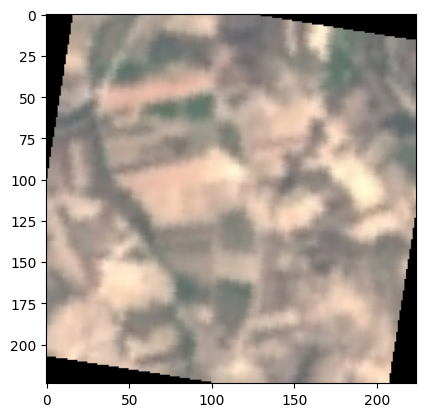

In [24]:
# Example data point visualization
random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)
plt.show()

# Residual Network Architecture

In [25]:
#Create the model class with ResNet
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [26]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16 
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16) 
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], 1)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        #self.avg_pool = nn.AvgPool2d(16) #original 16
        #self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Use adaptive pooling to reduce to 1x1
        #self.fc = nn.Linear(64, num_classes)  # Input size matches the flattened output
        # Adjust the pooling to reduce the feature map appropriately
        self.avg_pool = nn.AdaptiveAvgPool2d(3)  # Pool to 3x3 feature map
        self.fc = nn.Linear(64 * 3 * 3, num_classes)  # Adjust the fully connected layer input size to match the flattened output
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        #print(out.shape)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

# Create models

In [27]:
# Create network
model_student = ResNet(ResidualBlock, [2, 2, 2], num_classes=len(class_names))

In [28]:
# Save the student model
model_path = './outputs/resnet16_dual.pth'

In [29]:
# Load pre-trained model for inference
#from classification.model.build import EfficientViT_M0
loaded_model = ResNet(ResidualBlock, [2, 2, 2])


# Load the state dictionary
loaded_model.load_state_dict(torch.load(model_path))

if USE_CUDA:
    loaded_model = loaded_model.cuda()

print('Model loaded and ready for inference')

Model loaded and ready for inference


/tmp/ipykernel_521804/507091157.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_student.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Loaded model test results: Loss=0.11436135225239995 | Accuracy=96.46477132262052
Precision: 0.9652419554484913 | Recall: 0.9646477132262052
Inference Time for Loaded Model: 6.587460517883301 seconds



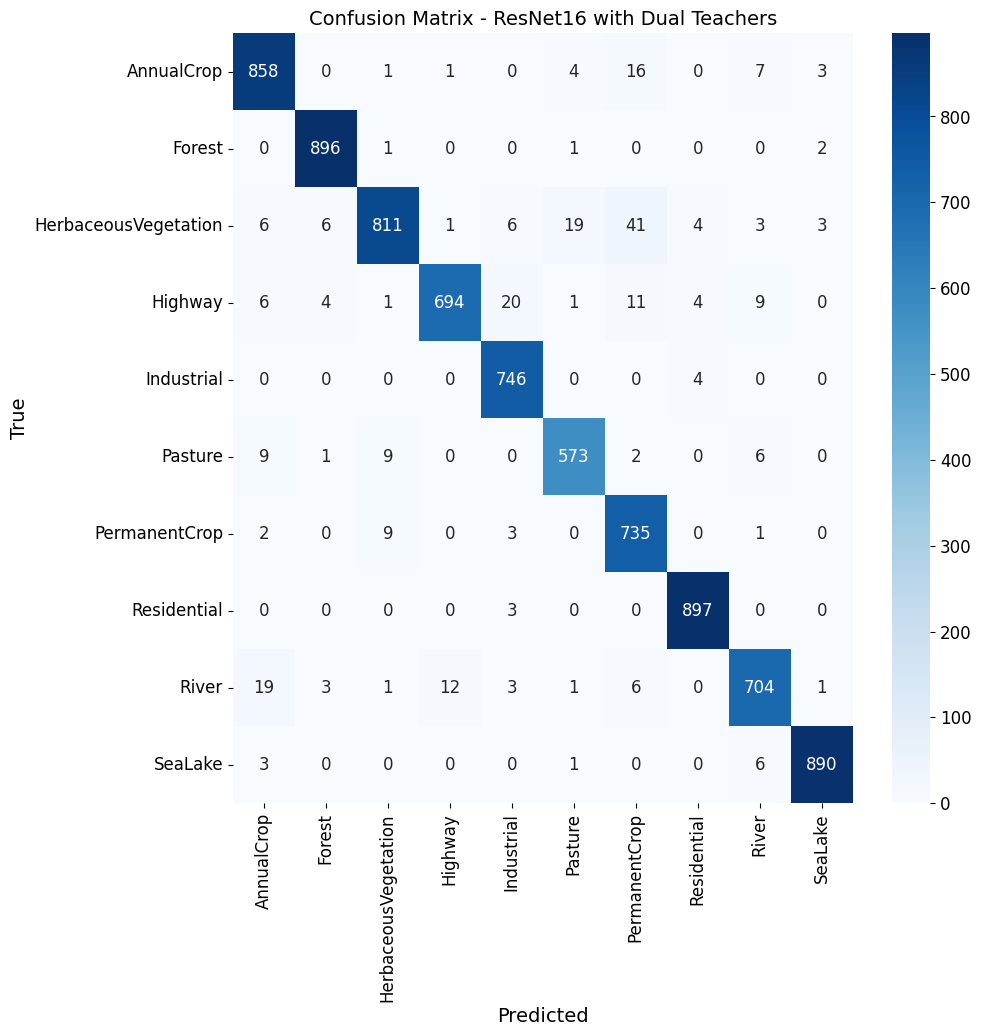

In [31]:
# Test the loaded model
loaded_model.eval()  # Put the network into evaluation mode

correct = 0
iterations = 0
testing_loss = 0.0
all_preds = []
all_labels = []

# Timing for inference of the loaded model
start_time = time.time()

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = loaded_model(inputs)#.logits
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        iterations += 1

# End timing for inference of the loaded model
end_time = time.time()
loaded_model_inference_time = end_time - start_time

test_loss_final = testing_loss / iterations
test_accuracy_final = 100.0 * correct / len(test_dataset)
precision_final = precision_score(all_labels, all_preds, average='weighted')
recall_final = recall_score(all_labels, all_preds, average='weighted')

print(f'\nLoaded model test results: Loss={test_loss_final} | Accuracy={test_accuracy_final}')
print(f'Precision: {precision_final} | Recall: {recall_final}')
print(f'Inference Time for Loaded Model: {loaded_model_inference_time} seconds\n')

# Confusion matrix for loaded model
conf_matrix_final = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
# Create the heatmap and assign it to the variable 'heatmap'
heatmap = sns.heatmap(conf_matrix_final, annot=True, annot_kws={"size":12}, fmt='d', cmap='Blues', 
                      xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix - ResNet16 with Dual Teachers', fontsize=14)
#plt.savefig('outputs/04-confusion-matrix_loaded_xLSTM.pdf')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the color bar tick size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # Change the font size of the color bar ticks

plt.show()